### Import Libraries

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

### Load Data

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

with h5py.File(CUBE_PATH, "r") as cube:
    spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
    images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]

In [3]:
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")

valid_sfrs = sfrs[(sfrs["FLAG"] == 0.0) & (sfrs["Z"].notna())].copy()
metadata_indices = metadata[:, 0]["ds_slice_idx"]
mask = np.in1d(metadata_indices, valid_sfrs.index)

### Process Data

In [4]:
spectra_filtered = spectra[mask]
images_filtered = images[mask]
metadata_indices_filtered = metadata_indices[mask]

In [5]:
labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]
redshifts = valid_sfrs.loc[metadata_indices_filtered, "Z"].values

In [6]:
def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    if "GALAXY" in val:
        return "GALAXY"
    elif "QSO" in val or "QA" in val:
        return "QUASAR"
    elif "STAR" in val:
        return "STAR"
    else:
        return "OTHER"

In [7]:
labels_simplified = pd.Series(labels).apply(simplify_targettype).values

In [8]:
nan_mask = ~np.isnan(spectra_filtered).any(axis=1)
spectra_filtered = spectra_filtered[nan_mask]
images_filtered = images_filtered[nan_mask]
labels_simplified = labels_simplified[nan_mask]
redshifts = redshifts[nan_mask]

In [9]:
filters = ["u", "g", "r", "i", "z"]
all_images = []
all_spectra = []
reference_spectrum = None
valid_indices = None

all_images = []
all_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"

    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask]
        spectra_zoom = cube[spec_key][:][mask]
    
    if zoom == 0:
        valid_indices = ~np.isnan(spectra_zoom).any(axis=1)
        reference_spectrum = spectra_zoom[valid_indices].copy()
        reference_images = images_zoom[valid_indices].copy()
    
    images_zoom = images_zoom[valid_indices]
    spectra_zoom = spectra_zoom[valid_indices]
    
    min_val_spec = np.min(reference_spectrum, axis=1, keepdims=True)
    max_val_spec = np.max(reference_spectrum, axis=1, keepdims=True)
    spectra_zoom_normalized = 2 * (spectra_zoom - min_val_spec) / (max_val_spec - min_val_spec) - 1
    
    min_val_img = np.min(reference_images, axis=(2, 3), keepdims=True)  
    max_val_img = np.max(reference_images, axis=(2, 3), keepdims=True)
    images_zoom_normalized = 2 * (images_zoom - min_val_img) / (max_val_img - min_val_img) - 1
    
    all_images.append(images_zoom_normalized)
    all_spectra.append(spectra_zoom_normalized)

u (ultraviolet) |
g (green) |
r (red) |
i (infrared) |
z (far infrared)

/tmp/ipykernel_1285199/380139196.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


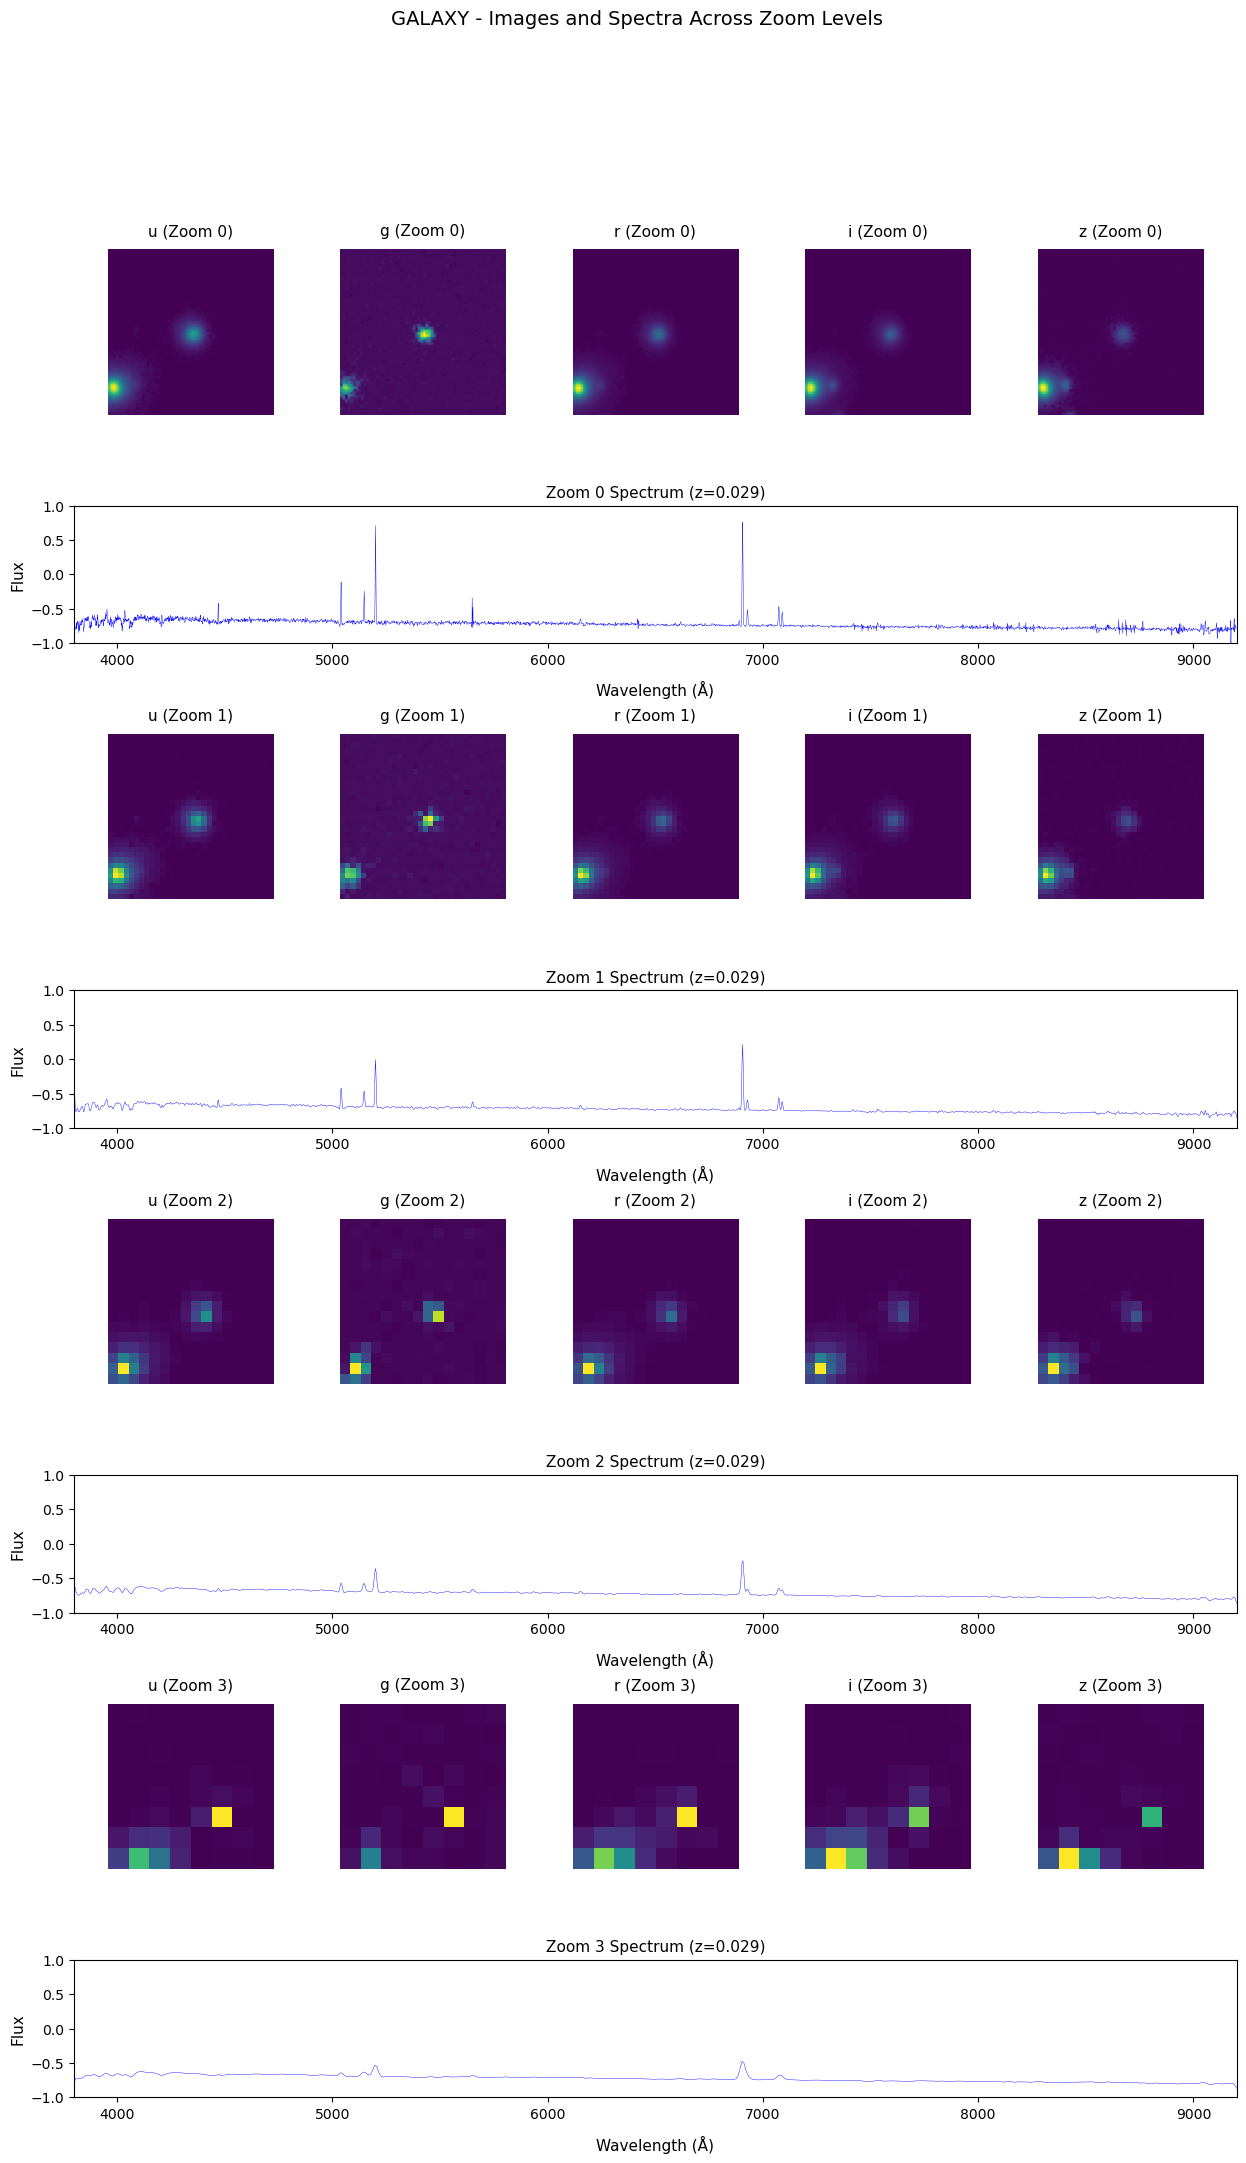

In [10]:
def plot_images_and_spectrum(images, spectra, labels, redshifts, class_name, obj_num):
    class_index = np.where(labels == class_name)[0]
    if len(class_index) == 0:
        print(f"No images found for class: {class_name}")
        return
    if obj_num >= len(class_index):
        print(f"Object index {obj_num} is out of range. Max available: {len(class_index)-1}")
        return
    
    idx = class_index[obj_num]
    if len(images) < 4 or len(spectra) < 4:
        print(f"Expected 4 zoom levels, but got {len(images)} images and {len(spectra)} spectra.")
        return
    
    fig = plt.figure(figsize=(15, 24))
    gs = gridspec.GridSpec(8, 5, height_ratios=[1.2, 1.0, 1.2, 1.0, 1.2, 1.0, 1.2, 1.0], hspace=0.6, wspace=0.0)
    
    for zoom in range(4):
        if idx >= len(images[zoom]):
            print(f"Index {idx} is out of bounds for zoom {zoom} images.")
            continue
        
        img_channels = images[zoom][idx]
        spectrum = spectra[zoom][idx]
        redshift = redshifts[idx] if not np.isnan(redshifts[idx]) else "N/A"
        
        for i in range(5):
            ax = fig.add_subplot(gs[zoom * 2, i])
            ax.imshow(img_channels[i], cmap="viridis")
            ax.set_title(f"{filters[i]} (Zoom {zoom})", fontsize=11, pad=10)
            ax.axis("off")
        
        ax_spec = fig.add_subplot(gs[zoom * 2 + 1, :])
        zoom_wavelengths = np.linspace(3800, 9200, len(spectrum))
        ax_spec.plot(zoom_wavelengths, spectrum, color="blue", linewidth=0.3)
        ax_spec.set_title(f"Zoom {zoom} Spectrum (z={redshift:.3f})", fontsize=11)
        ax_spec.set_xlabel("Wavelength (Å)", fontsize=11, labelpad=10)
        ax_spec.set_ylabel("Flux", fontsize=11)
        ax_spec.set_xlim([3800, 9200])
        ax_spec.set_ylim([-1, 1])  # Фиксируем ось Y от -1 до 1
        
    fig.suptitle(f"{class_name} - Images and Spectra Across Zoom Levels", fontsize=14)
    plt.tight_layout()
    plt.show()

for i in range(1):
    plot_images_and_spectrum(all_images, all_spectra, labels_simplified, redshifts, "GALAXY", i)


# Machine Learning for Z

In [11]:
z_mean = np.mean(redshifts)
y_pred_baseline = np.full_like(redshifts, z_mean)
mae_baseline = mean_absolute_error(redshifts, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(redshifts, y_pred_baseline))

print(f"Baseline (Mean Z) MAE: {mae_baseline:.5f}")
print(f"Baseline (Mean Z) RMSE: {rmse_baseline:.5f}")

Baseline (Mean Z) MAE: 0.05244
Baseline (Mean Z) RMSE: 0.06599


### RF

In [12]:
print(all_images[0].reshape(all_images[0].shape[0], -1).shape)
print(all_images[3].shape)

(11179, 20480)
(11179, 5, 8, 8)


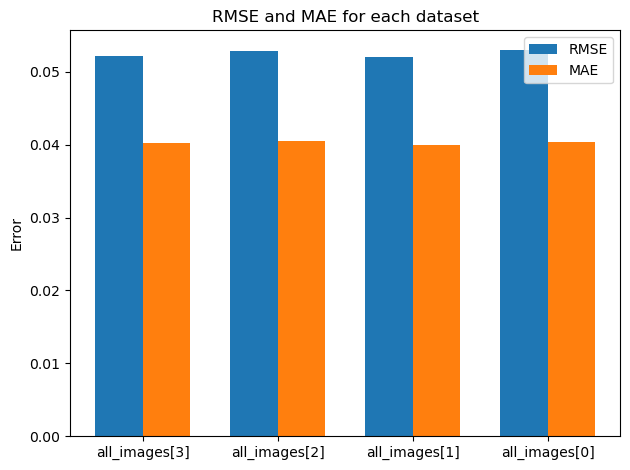

In [13]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    mae = mean_absolute_error(y_val, predictions)
    return rmse, mae

def find_best_params(images, redshifts):
    images_flattened = images.reshape(images.shape[0], -1)
    X_train, X_temp, y_train, y_temp = train_test_split(images_flattened, redshifts, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    n_estimators_range = [9]
    max_depth_range = [5, 7]
    min_samples_split_range = [4]
    
    results = []
    
    for n_estimators in n_estimators_range:
        for max_depth in max_depth_range:
            for min_samples_split in min_samples_split_range:
                rf_model = RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    random_state=42
                )
                rmse_val, mae_val = evaluate_model(rf_model, X_train, y_train, X_val, y_val)
                results.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'rmse': rmse_val,
                    'mae': mae_val
                })
    
    results_array = np.array([(r['n_estimators'], r['max_depth'], r['min_samples_split'], r['rmse'], r['mae']) for r in results])
    best_result = results[np.argmin(results_array[:, 3])]
    
    return best_result

def apply_best_params(images, redshifts, best_params):
    images_flattened = images.reshape(images.shape[0], -1)
    X_train, X_temp, y_train, y_temp = train_test_split(images_flattened, redshifts, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    rf_model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        random_state=42
    )
    
    rmse_val, mae_val = evaluate_model(rf_model, X_train, y_train, X_val, y_val)
    
    return rmse_val, mae_val

def visualize_results(results):
    labels = ['all_images[3]', 'all_images[2]', 'all_images[1]', 'all_images[0]']
    rmses = [result['rmse'] for result in results]
    maes = [result['mae'] for result in results]
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, rmses, width, label='RMSE')
    rects2 = ax.bar(x + width/2, maes, width, label='MAE')
    
    ax.set_ylabel('Error')
    ax.set_title('RMSE and MAE for each dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    fig.tight_layout()
    plt.show()

best_params = find_best_params(all_images[3], redshifts)

results = []
for i in range(4):
    rmse, mae = apply_best_params(all_images[i], redshifts, best_params)
    results.append({'rmse': rmse, 'mae': mae})

visualize_results(results)

Random Forest: "RANDOM FORESTS FOR PHOTOMETRIC REDSHIFTS" (https://iopscience.iop.org/article/10.1088/0004-637X/712/1/511/meta)

### CNN

In [14]:
def prepare_data(images, redshifts):
    X = images.reshape(images.shape[0], -1, images.shape[-1])
    X = np.expand_dims(X, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, redshifts, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def create_model(input_shape):
    class CNNModel(nn.Module):
        def __init__(self):
            super(CNNModel, self).__init__()
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
            self.relu1 = nn.ReLU()
            self.pool1 = nn.MaxPool2d(2)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.relu2 = nn.ReLU()
            self.pool2 = nn.MaxPool2d(2)
            self.flatten = nn.Flatten()
            self.fc1_input_size = 64 * (input_shape[0] // 4) * (input_shape[1] // 4)
            self.fc1 = nn.Linear(self.fc1_input_size, 128)
            self.relu3 = nn.ReLU()
            self.fc2 = nn.Linear(128, 1)

        def forward(self, x):
            x = self.pool1(self.relu1(self.conv1(x)))
            x = self.pool2(self.relu2(self.conv2(x)))
            x = self.flatten(x)
            x = self.relu3(self.fc1(x))
            x = self.fc2(x)
            return x

    return CNNModel()

def train_model(model, train_loader, test_loader, epochs, loss_fn, optimizer):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            target = target.view(-1, 1)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                target = target.view(-1, 1)
                loss = loss_fn(output, target)
                epoch_val_loss += loss.item()
        
        epoch_val_loss /= len(test_loader)
        val_losses.append(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch + 1
            best_model_state = model.state_dict()

        print(f'Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}')

    return best_epoch, best_model_state, train_losses, val_losses

def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            predictions.extend(output.numpy().flatten())
            targets.extend(target.numpy().flatten())
    
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    return rmse, mae

Epoch 1, Train Loss: 0.004668, Val Loss: 0.002967
Epoch 2, Train Loss: 0.003059, Val Loss: 0.002769
Epoch 3, Train Loss: 0.003025, Val Loss: 0.002758
Epoch 4, Train Loss: 0.002969, Val Loss: 0.002788
Epoch 5, Train Loss: 0.002827, Val Loss: 0.002823
Epoch 6, Train Loss: 0.002851, Val Loss: 0.002896
Epoch 7, Train Loss: 0.002906, Val Loss: 0.003148
Epoch 8, Train Loss: 0.002815, Val Loss: 0.002952
Epoch 9, Train Loss: 0.002794, Val Loss: 0.002683
Epoch 10, Train Loss: 0.002747, Val Loss: 0.003034
Epoch 11, Train Loss: 0.002729, Val Loss: 0.002680
Epoch 12, Train Loss: 0.002718, Val Loss: 0.002583
Epoch 13, Train Loss: 0.002647, Val Loss: 0.002575
Epoch 14, Train Loss: 0.002647, Val Loss: 0.002594
Epoch 15, Train Loss: 0.002628, Val Loss: 0.002716
Epoch 16, Train Loss: 0.002626, Val Loss: 0.002504
Epoch 17, Train Loss: 0.002586, Val Loss: 0.002722
Epoch 18, Train Loss: 0.002579, Val Loss: 0.002506
Epoch 19, Train Loss: 0.002552, Val Loss: 0.002527
Epoch 20, Train Loss: 0.002534, Val Loss

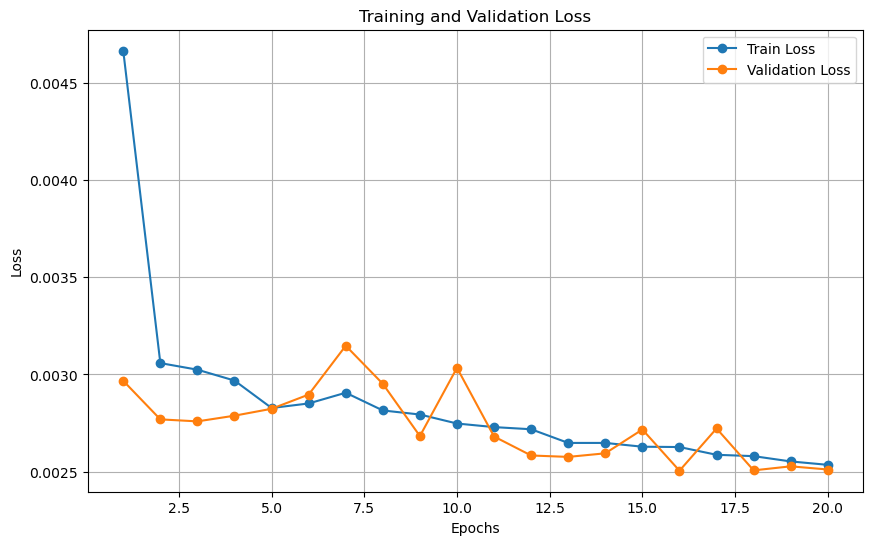

Best Epoch: 16
RMSE on all_images[3]: 0.0501
MAE on all_images[3]: 0.0382


In [15]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = prepare_data(all_images[3], redshifts)

X_train_tensor = torch.Tensor(X_train_cnn)
y_train_tensor = torch.Tensor(y_train_cnn)
X_test_tensor = torch.Tensor(X_test_cnn)
y_test_tensor = torch.Tensor(y_test_cnn)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

cnn_model = create_model(X_train_cnn.shape[2:])

optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

epochs = 20
best_epoch, best_model_state, train_losses, val_losses = train_model(
    cnn_model, train_loader, test_loader, epochs, loss_fn, optimizer
)

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

cnn_model.load_state_dict(best_model_state)

rmse, mae = evaluate_model(cnn_model, test_loader)
print(f"Best Epoch: {best_epoch}")
print(f"RMSE on all_images[3]: {rmse:.4f}")
print(f"MAE on all_images[3]: {mae:.4f}")

Epoch 1, Train Loss: 0.448204, Val Loss: 0.002933
Epoch 2, Train Loss: 0.002847, Val Loss: 0.002672
Epoch 3, Train Loss: 0.002662, Val Loss: 0.002860
Epoch 4, Train Loss: 0.002489, Val Loss: 0.002637
Epoch 5, Train Loss: 0.002284, Val Loss: 0.002668
Epoch 6, Train Loss: 0.002079, Val Loss: 0.002617
Epoch 7, Train Loss: 0.001862, Val Loss: 0.002786
Epoch 8, Train Loss: 0.001669, Val Loss: 0.002819
Epoch 9, Train Loss: 0.001458, Val Loss: 0.002758
Epoch 10, Train Loss: 0.001314, Val Loss: 0.002881
Epoch 11, Train Loss: 0.001174, Val Loss: 0.003034
Epoch 12, Train Loss: 0.001092, Val Loss: 0.002900
Epoch 13, Train Loss: 0.001014, Val Loss: 0.003150
Epoch 14, Train Loss: 0.000923, Val Loss: 0.003168
Epoch 15, Train Loss: 0.000889, Val Loss: 0.003124
Epoch 16, Train Loss: 0.000822, Val Loss: 0.003117
Epoch 1, Train Loss: 0.044317, Val Loss: 0.002725
Epoch 2, Train Loss: 0.002821, Val Loss: 0.002675
Epoch 3, Train Loss: 0.002645, Val Loss: 0.002536
Epoch 4, Train Loss: 0.002508, Val Loss: 0.

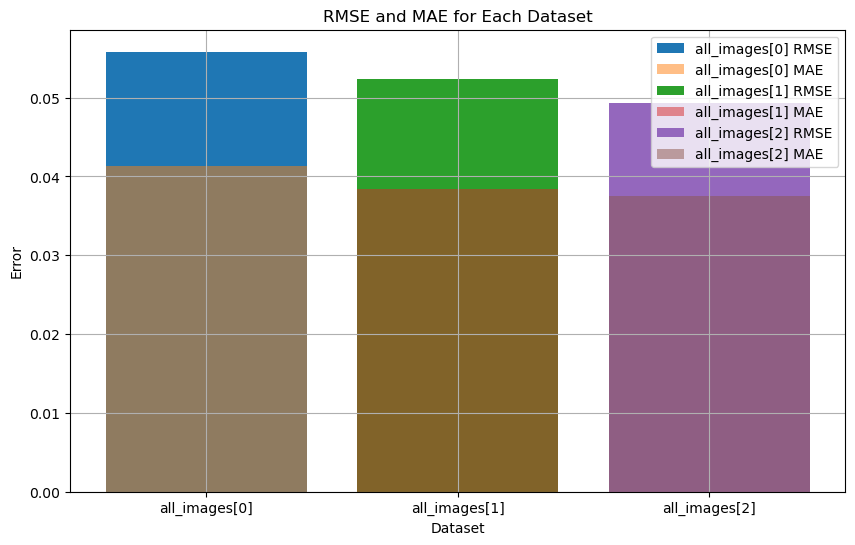

In [16]:
results = {}
for i in range(3):  
    X_train, X_test, y_train, y_test = prepare_data(all_images[i], redshifts)

    X_train_tensor = torch.Tensor(X_train) 
    y_train_tensor = torch.Tensor(y_train) 
    X_test_tensor = torch.Tensor(X_test)    
    y_test_tensor = torch.Tensor(y_test)   
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    cnn_model = create_model(X_train.shape[2:]) 
    
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    _, best_model_state, _, _ = train_model(
        cnn_model, train_loader, test_loader, best_epoch, loss_fn, optimizer
    )

    cnn_model.load_state_dict(best_model_state)
    
    rmse, mae = evaluate_model(cnn_model, test_loader)
    results[f'all_images[{i}]'] = {'RMSE': rmse, 'MAE': mae}

plt.figure(figsize=(10, 6))
for key, value in results.items():
    plt.bar(key, value['RMSE'], label=f'{key} RMSE')
    plt.bar(key, value['MAE'], label=f'{key} MAE', alpha=0.5)
plt.xlabel('Dataset')
plt.ylabel('Error')
plt.title('RMSE and MAE for Each Dataset')
plt.legend()
plt.grid(True)
plt.show()

Deep CNN: "Photometric redshifts from SDSS images using a Convolutional Neural Network" 

https://arxiv.org/abs/1806.06607

https://academic.oup.com/mnras/article/512/2/1696/6536923